In [36]:
import cv2
import os
import warnings
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import platform
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

%reload_ext nb_black
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
CUSTOM_MODEL_NAME = "my_ssd_mobnet"
PRETRAINED_MODEL_NAME = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
PRETRAINED_MODEL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz"
TF_RECORD_SCRIPT_NAME = "generate_tfrecord.py"
LABEL_MAP_NAME = "label_map.pbtxt"
current_os = platform.system()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
parent_directory = os.path.dirname(os.getcwd())
paths = {
    "SRC_PATH": os.path.join(parent_directory, "src"),
    "DATA_PATH": os.path.join(parent_directory, "data"),
    "APIMODEL_PATH": os.path.join(parent_directory, "api_models"),
    "MODEL_PATH": os.path.join(parent_directory, "my_models"),
    "PRETRAINED_MODEL_PATH": os.path.join(parent_directory, "pre-trained-models"),
    "CHECKPOINT_PATH": os.path.join(parent_directory, "my_models", CUSTOM_MODEL_NAME),
    "OUTPUT_PATH": os.path.join(
        parent_directory, "my_models", CUSTOM_MODEL_NAME, "export"
    ),
    "TFJS_PATH": os.path.join(
        parent_directory, "my_models", CUSTOM_MODEL_NAME, "tfjsexport"
    ),
    "TFLITE_PATH": os.path.join(
        parent_directory, "my_models", CUSTOM_MODEL_NAME, "tfliteexport"
    ),
    "PROTOC_PATH": os.path.join(parent_directory, "protoc"),
    "VIDEOS_PATH": os.path.join(parent_directory, "videos"),
}
mice = [
    "PrL-2",
    "PrL-3",
    "PrL-4",
    "PrL-5",
    "PrL-8",
    "PrL-9",
    "PrL-10",
    "PrL-16",
    "PrL-19",
]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
files = {
    "PIPELINE_CONFIG": os.path.join(
        parent_directory, "my_models", CUSTOM_MODEL_NAME, "pipeline.config"
    ),
    "TF_RECORD_SCRIPT": os.path.join(paths["DATA_PATH"], TF_RECORD_SCRIPT_NAME),
    "LABELMAP": os.path.join(paths["DATA_PATH"], LABEL_MAP_NAME),
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files["PIPELINE_CONFIG"])
detection_model = model_builder.build(model_config=configs["model"], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths["CHECKPOINT_PATH"], "ckpt-3")).expect_partial()


@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

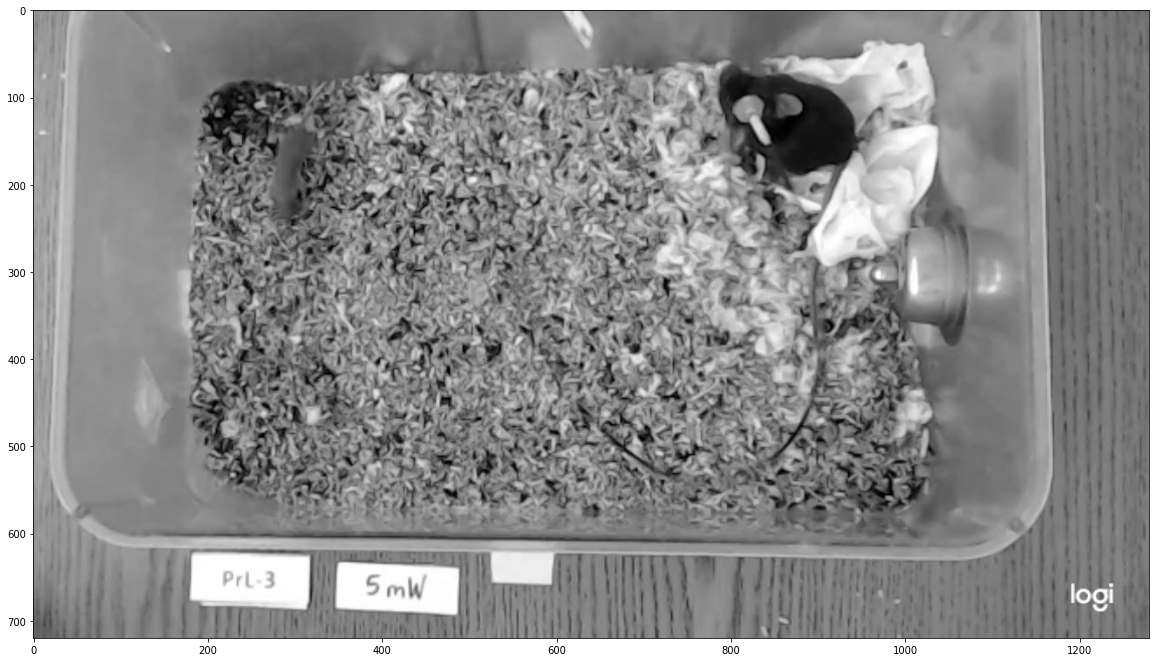

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
img_path = (
    f'{paths["DATA_PATH"]}/train/child_PrL-3-d99f9f63-1612-470f-b36d-9ec1e6ef9dc1.jpg'
)
img_arr = np.asarray(cv2.imread(img_path))
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(pil_im))
plt.show()

In [80]:
input_tensor = tf.convert_to_tensor(np.expand_dims(img_arr, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [81]:
num_detections = int(detections.pop("num_detections"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
detections = {
    key: np.asarray(value[0, :num_detections]) for key, value in detections.items()
}
detections

{'detection_boxes': array([[0.12686601, 0.20000914, 0.31003666, 0.37528047],
        [0.8019554 , 0.82859564, 0.9591082 , 0.996994  ],
        [0.        , 0.        , 0.8387531 , 1.        ],
        [0.66390896, 0.04857577, 0.80994606, 0.21742229],
        [0.5415531 , 0.03801626, 0.77797467, 0.18753031],
        [0.08591511, 0.5357259 , 0.28816366, 0.708474  ],
        [0.4079149 , 0.01015133, 0.6386028 , 0.16487323],
        [0.5049573 , 0.01652369, 0.7389395 , 0.1689857 ],
        [0.00360627, 0.19709982, 0.11767687, 0.37362212],
        [0.66478026, 0.20107716, 0.8097948 , 0.36492538],
        [0.31212547, 0.00738628, 0.5421777 , 0.1626422 ],
        [0.26214707, 0.34231064, 0.47359532, 0.47802868],
        [0.8289005 , 0.02013931, 0.9836857 , 0.1916216 ],
        [0.71863735, 0.71347415, 1.        , 1.        ],
        [0.        , 0.        , 1.        , 1.        ],
        [0.45054948, 0.02602738, 0.688056  , 0.18382454],
        [0.08815528, 0.5062272 , 0.28421172, 0.657758

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
category_index = label_map_util.create_category_index_from_labelmap(files["LABELMAP"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [93]:
category_index

{1: {'id': 1, 'name': 'parent-mice'}, 2: {'id': 2, 'name': 'child-mice'}}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
detections["detection_classes"].shape

(100,)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [96]:
detections["detection_scores"].shape

(100,)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

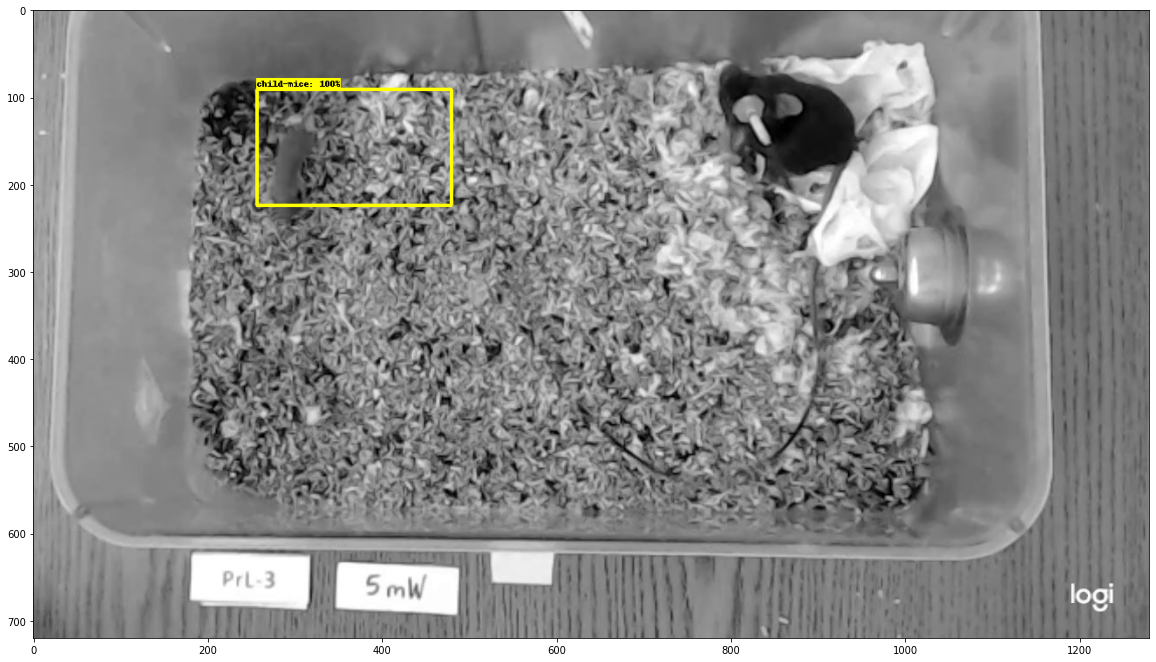

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
detections["num_detections"] = num_detections

# detection_classes should be ints.
detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

label_id_offset = 2
image_np_with_detections = img_arr.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections["detection_boxes"],
    detections["detection_classes"] + label_id_offset,
    detections["detection_scores"],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=0.8,
    agnostic_mode=False,
)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [101]:
cap = cv2.VideoCapture(f'{paths["VIDEOS_PATH"]}/PrL-4.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    ret, frame = cap.read()
    image_np = np.array(frame)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop("num_detections"))
    detections = {
        key: np.asarray(value[0, :num_detections]) for key, value in detections.items()
    }
    detections["num_detections"] = num_detections

    # detection_classes should be ints.
    detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections["detection_boxes"],
        detections["detection_classes"] + label_id_offset,
        detections["detection_scores"],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,
        min_score_thresh=0.8,
        agnostic_mode=False,
    )

    cv2.imshow("object detection", cv2.resize(image_np_with_detections, (800, 600)))

    if cv2.waitKey(10) & 0xFF == ord("q"):
        cap.release()
        cv2.destroyAllWindows()
        break

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>